<a href="https://colab.research.google.com/github/exem-ai-isoh/Hands-On-Machine-Learning/blob/master/autoencoders_and_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Tying weights
Auto Encoder가 완벽한 대칭일 경우 일반적으로 가중치를 묶는 것이 일반적이다. 이를 통해 가중치의 수를 절반으로 줄여서 훈련의 속도를 높이고 과대적합의 위험을 줄인다.

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 9s 6ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3014 - val_rounded_accuracy: 0.9093
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2873 - val_rounded_accuracy: 0.9316
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2860 - val_rounded_accuracy: 0.9354
Epoch 7/10
1719/1719 [=================

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

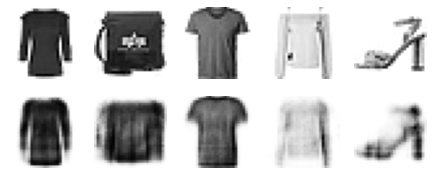

In [ ]:
show_reconstructions(tied_ae)
plt.show()

# Training one Autoencoder at a Time
오토 인코더 하나를 훈련하고 이를 쌓아올려서 한 개의 적층 오토인코더를 만들 수 있습니다. 이러한 방법은 greedy layerwise training에 관해 이야기할 때 종종 등장합니다.
- greedy layerwise training: 
https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=laonple&logNo=220884698923


In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [=================

In [ ]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

In [ ]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

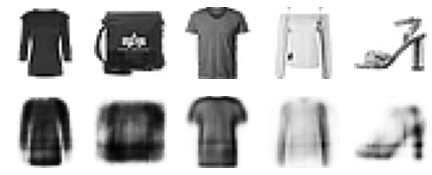

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()